# Denoising Autoencoder

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dae-encoder-1/pytorch/default/1/encoder_layer1.pth
/kaggle/input/dae-encoder-2/pytorch/default/1/encoder_layer2 (1).pth
/kaggle/input/dae-encoder-3/pytorch/default/1/encoder_layer3.pth


## Imports

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap

2026-01-22 17:08:47.350198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769101727.885274      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769101728.067755      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769101729.397239      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769101729.397285      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769101729.397288      55 computation_placer.cc:177] computation placer alr

## Model

### Deterministic Single Layer Encoder

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_size, output_size):
        super(Encoder, self).__init__()
        
        #Initialize params
        self.input_size = input_size
        self.output_size = output_size

        # Activation Function
        self.activation = nn.Sigmoid()
        
        self.latent_space = nn.Linear(self.input_size, self.output_size)

    def forward(self, X):
        X = self.latent_space(X)
        X = self.activation(X)
        return X

### Deterministic Single Layer Decoder

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_space_size, input_size):
        super(Decoder, self).__init__()
        
        #Initialize params
        self.latent_space_size = latent_space_size
        self.input_size = input_size
        
        self.reconstruction = nn.Linear(self.latent_space_size, self.input_size)

    def forward(self, X):
        X = self.reconstruction(X)
        return X

## Corrution

In [5]:
def random_sampling_without_replacement(low, high, num_samples):
    n = high - low
    perm = torch.randperm(n)
    
    # Select the first 'num_samples' indices
    indices = perm[:num_samples]
    
    # Add 'low' back to the indices to get the final values in the desired range
    result = low + indices
    return result

In [6]:
def corrupt(x: torch.Tensor, v):
    B, d = x.shape
    # number of components to zero
    vd = math.floor(v*d)
    x_ret = x.clone().detach()
    for i in range(B):       
        zeros = random_sampling_without_replacement(0,d,vd)
        for j in zeros:
            x_ret[i, j] = 0

    return x_ret, x

## DAE

In [7]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_size, latent_space_size):
        super(DenoisingAutoencoder, self).__init__()

        self.input_size = input_size
        self.latent_space_size = latent_space_size
        
        self.encoder = Encoder(input_size, latent_space_size)
        self.decoder = Decoder(latent_space_size, input_size)

    def forward(self, X):
        X = X.view(X.size(0), -1) 
        z = self.encoder(X)
        reconstruction = self.decoder(z)
        return reconstruction

## Pretraining Setup

In [8]:
def train_layer(model, optimizer, criterion, dataloader, device, v, update_freq=10):
    model.train()
    
    total_loss = 0.0
    num_batches = len(dataloader)

    for batch_idx, batch in enumerate(dataloader):
        features = batch[0].to(device)
        
        features = nn.Flatten()(features)
        
        corrupted_features, labels = corrupt(features, v)  # Corrupt here
        
        optimizer.zero_grad()

        outputs = model(corrupted_features)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        if (batch_idx + 1) % update_freq == 0:
            print(f'   Batch [{batch_idx+1}/{len(dataloader)}] - Loss: {loss.item():.4f}')

    avg_loss = total_loss / num_batches
    return avg_loss


In [9]:
def evaluate(model, dataloader, criterion, device):
    model.eval()

    total_loss = 0.0
    num_batches = len(dataloader)

    with torch.no_grad():
        for features, _ in dataloader:
            features = features.to(device)
            
            features = nn.Flatten()(features)

            outputs = model(features)
            loss = criterion(outputs, features)

            total_loss +=loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

In [10]:
def train_dae(num_epochs, model, train_dataloader, test_dataloader, criterion, optimizer, device, update_freq, v):
    train_losses = []
    test_losses = []
    
    start_time = time.time()

    model.to(device)

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        print("-" * 50)
        
        #Train
        print("INFO - Training...")
        train_loss = train_layer(model, optimizer, criterion, train_dataloader, device, v, update_freq=update_freq)
        
        #Eval
        print("INFO - Evaluating...")
        test_loss = evaluate(model, test_dataloader, criterion, device)
        
        # Store metrics
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        epoch_time = time.time() - epoch_start_time
        
    total_time = time.time() - start_time
    print("\n" + "=" * 80)
    print("✅ Training completed!")
    print(f"🕒 Total training time: {total_time:.2f}s ({total_time/60:.1f} minutes)")
    
    return train_losses, test_losses
        

In [11]:
def compute_next_layer_dataloaders(
    encoder,
    train_dataloader,
    test_dataloader,
    device,
    batch_size,
    num_workers=0,
    flatten_input=False,   # <-- explicit and honest
):
    encoder.to(device)
    encoder.eval()

    def encode_dataset(dataloader):
        reps = []

        with torch.no_grad():
            for x, _ in dataloader:
                x = x.to(device)

                if flatten_input:
                    x = torch.flatten(x, start_dim=1)

                h = encoder(x)
                reps.append(h.cpu())

        H = torch.cat(reps, dim=0)
        dummy = torch.zeros(len(H))  # unused labels

        return TensorDataset(H, dummy)

    train_ds = encode_dataset(train_dataloader)
    test_ds  = encode_dataset(test_dataloader)

    train_dl = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    test_dl = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dl, test_dl

### Dataset and Dataloader

In [12]:
def download_MNIST_DAE():
    transform = transforms.Compose([
        transforms.ToTensor(),  # scales to [0, 1]
    ])

    train_dataset = torchvision.datasets.MNIST(
        root='../data/train',
        train=True,
        download=True,
        transform=transform
    )

    test_dataset = torchvision.datasets.MNIST(
        root='../data/test',
        train=False,
        download=True,
        transform=transform
    )

    return train_dataset, test_dataset

In [13]:
def create_DataLoaders(train_dataset, test_dataset, batch_size, shuffle_train, num_workers):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=shuffle_train,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, test_loader

## Pretraining

In [14]:
BATCH_SIZE = 512
NUM_EPOCHS = 15
NUM_WORKERS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
V = 0.20

### Layer 1

In [14]:
train_dataset, test_dataset = download_MNIST_DAE()

train_dataloader, test_dataloader = create_DataLoaders(train_dataset, test_dataset, batch_size=BATCH_SIZE, shuffle_train=True, num_workers=NUM_WORKERS)

model = DenoisingAutoencoder(input_size=784, latent_space_size=2000)
model.to(DEVICE)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_losses, test_losses = train_dae(num_epochs=NUM_EPOCHS, train_dataloader=train_dataloader, test_dataloader=test_dataloader, model=model, criterion=criterion, optimizer=optimizer, device=DEVICE, update_freq=100, v=V)


Epoch [1/15]
--------------------------------------------------
INFO - Training...
   Batch [100/118] - Loss: 0.3480
INFO - Evaluating...

Epoch [2/15]
--------------------------------------------------
INFO - Training...
   Batch [100/118] - Loss: 0.2922
INFO - Evaluating...

Epoch [3/15]
--------------------------------------------------
INFO - Training...
   Batch [100/118] - Loss: 0.2827
INFO - Evaluating...

Epoch [4/15]
--------------------------------------------------
INFO - Training...
   Batch [100/118] - Loss: 0.2774
INFO - Evaluating...

Epoch [5/15]
--------------------------------------------------
INFO - Training...
   Batch [100/118] - Loss: 0.2697
INFO - Evaluating...

Epoch [6/15]
--------------------------------------------------
INFO - Training...
   Batch [100/118] - Loss: 0.2686
INFO - Evaluating...

Epoch [7/15]
--------------------------------------------------
INFO - Training...
   Batch [100/118] - Loss: 0.2683
INFO - Evaluating...

Epoch [8/15]
-------------

In [17]:
encoder_1 = model.encoder
for param in encoder_1.parameters():
    param.requires_grad = False

encoder_1.eval()
torch.save(encoder_1.state_dict(), "encoder_layer1.pth")

### Layer 2

In [17]:
model_1 = DenoisingAutoencoder(input_size=784, latent_space_size=2000)
encoder_1 = model_1.encoder
encoder_1.load_state_dict(torch.load("/kaggle/input/dae-encoder-1/pytorch/default/1/encoder_layer1.pth"))
encoder_1.eval()

Encoder(
  (activation): Sigmoid()
  (latent_space): Linear(in_features=784, out_features=2000, bias=True)
)

In [18]:
train_dataset, test_dataset = download_MNIST_DAE()
train_dataloader, test_dataloader = create_DataLoaders(train_dataset, test_dataset, batch_size=BATCH_SIZE, shuffle_train=True, num_workers=NUM_WORKERS)

train_dataloader_2, test_dataloader_2 = compute_next_layer_dataloaders(encoder_1, train_dataloader, test_dataloader, DEVICE, BATCH_SIZE, NUM_WORKERS, flatten_input=True)

model_2 = DenoisingAutoencoder(input_size=2000, latent_space_size=1000)
model_2.to(DEVICE)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9)

train_losses, test_losses = train_dae(num_epochs=NUM_EPOCHS, train_dataloader=train_dataloader_2, test_dataloader=test_dataloader_2, model=model_2, criterion=criterion, optimizer=optimizer, device=DEVICE, update_freq=100, v=V)

100%|██████████| 9.91M/9.91M [00:00<00:00, 40.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.13MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.77MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.84MB/s]
100%|██████████| 9.91M/9.91M [00:00<00:00, 33.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.06MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.72MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.06MB/s]



Epoch [1/15]
--------------------------------------------------
INFO - Training...
   Batch [100/118] - Loss: 0.6978
INFO - Evaluating...

Epoch [2/15]
--------------------------------------------------
INFO - Training...
   Batch [100/118] - Loss: 0.6940
INFO - Evaluating...

Epoch [3/15]
--------------------------------------------------
INFO - Training...
   Batch [100/118] - Loss: 0.6923
INFO - Evaluating...

Epoch [4/15]
--------------------------------------------------
INFO - Training...
   Batch [100/118] - Loss: 0.6914
INFO - Evaluating...

Epoch [5/15]
--------------------------------------------------
INFO - Training...
   Batch [100/118] - Loss: 0.6911
INFO - Evaluating...

Epoch [6/15]
--------------------------------------------------
INFO - Training...
   Batch [100/118] - Loss: 0.6910
INFO - Evaluating...

Epoch [7/15]
--------------------------------------------------
INFO - Training...
   Batch [100/118] - Loss: 0.6909
INFO - Evaluating...

Epoch [8/15]
-------------

In [19]:
encoder_2 = model_2.encoder
for param in encoder_2.parameters():
    param.requires_grad = False

encoder_2.eval()
torch.save(encoder_2.state_dict(), "encoder_layer2.pth")

### Layer 3

In [15]:
model_1 = DenoisingAutoencoder(input_size=784, latent_space_size=2000)
encoder_1 = model_1.encoder
encoder_1.load_state_dict(torch.load("/kaggle/input/dae-encoder-1/pytorch/default/1/encoder_layer1.pth"))
encoder_1.eval()

Encoder(
  (activation): Sigmoid()
  (latent_space): Linear(in_features=784, out_features=2000, bias=True)
)

In [16]:
model_2 = DenoisingAutoencoder(input_size=2000, latent_space_size=1000)
encoder_2 = model_2.encoder
encoder_2.load_state_dict(torch.load("/kaggle/input/dae-encoder-2/pytorch/default/1/encoder_layer2 (1).pth"))
encoder_2.eval()

Encoder(
  (activation): Sigmoid()
  (latent_space): Linear(in_features=2000, out_features=1000, bias=True)
)

In [17]:
train_dataset, test_dataset = download_MNIST_DAE()
train_dataloader, test_dataloader = create_DataLoaders(train_dataset, test_dataset, batch_size=BATCH_SIZE, shuffle_train=True, num_workers=NUM_WORKERS)
train_dataloader_2, test_dataloader_2 = compute_next_layer_dataloaders(encoder_1, train_dataloader, test_dataloader, DEVICE, BATCH_SIZE, NUM_WORKERS, flatten_input=True)
train_dataloader_3, test_dataloader_3 = compute_next_layer_dataloaders(encoder_2, train_dataloader_2, test_dataloader_2, DEVICE, BATCH_SIZE, NUM_WORKERS, flatten_input=False)

model = DenoisingAutoencoder(input_size=1000, latent_space_size=500)
model.to(DEVICE)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_losses, test_losses = train_dae(num_epochs=NUM_EPOCHS, train_dataloader=train_dataloader_3, test_dataloader=test_dataloader_3, model=model, criterion=criterion, optimizer=optimizer, device=DEVICE, update_freq=100, v=V)

100%|██████████| 9.91M/9.91M [00:00<00:00, 39.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.10MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.88MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.72MB/s]
100%|██████████| 9.91M/9.91M [00:00<00:00, 43.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.13MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.72MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.4MB/s]



Epoch [1/15]
--------------------------------------------------
INFO - Training...
   Batch [100/118] - Loss: 0.6937
INFO - Evaluating...

Epoch [2/15]
--------------------------------------------------
INFO - Training...
   Batch [100/118] - Loss: 0.6867
INFO - Evaluating...

Epoch [3/15]
--------------------------------------------------
INFO - Training...
   Batch [100/118] - Loss: 0.6835
INFO - Evaluating...

Epoch [4/15]
--------------------------------------------------
INFO - Training...
   Batch [100/118] - Loss: 0.6820
INFO - Evaluating...

Epoch [5/15]
--------------------------------------------------
INFO - Training...
   Batch [100/118] - Loss: 0.6814
INFO - Evaluating...

Epoch [6/15]
--------------------------------------------------
INFO - Training...
   Batch [100/118] - Loss: 0.6811
INFO - Evaluating...

Epoch [7/15]
--------------------------------------------------
INFO - Training...
   Batch [100/118] - Loss: 0.6809
INFO - Evaluating...

Epoch [8/15]
-------------

In [18]:
encoder_3 = model.encoder
for param in encoder_3.parameters():
    param.requires_grad = False

encoder_3.eval()

Encoder(
  (activation): Sigmoid()
  (latent_space): Linear(in_features=1000, out_features=500, bias=True)
)

In [19]:
torch.save(encoder_3.state_dict(), "encoder_layer3.pth")

## Stacking

In [17]:
class StackedDenoisingAutoencoder3(nn.Module):
    def __init__(self, layer_1, layer_2, layer_3):
        super(StackedDenoisingAutoencoder3, self).__init__()
        self.encoder1 = layer_1
        self.encoder2 = layer_2
        self.encoder3 = layer_3

    def forward(self, X):
        X = self.encoder1(X)
        X = self.encoder2(X)
        X = self.encoder3(X)
        return X

In [18]:
model_1 = DenoisingAutoencoder(input_size=784, latent_space_size=2000)
encoder_1 = model_1.encoder
encoder_1.load_state_dict(torch.load("/kaggle/input/dae-encoder-1/pytorch/default/1/encoder_layer1.pth"))
print(encoder_1.eval())

model_2 = DenoisingAutoencoder(input_size=2000, latent_space_size=1000)
encoder_2 = model_2.encoder
encoder_2.load_state_dict(torch.load("/kaggle/input/dae-encoder-2/pytorch/default/1/encoder_layer2 (1).pth"))
print(encoder_2.eval())

model_3 = DenoisingAutoencoder(input_size=1000, latent_space_size=500)
encoder_3 = model_3.encoder
encoder_3.load_state_dict(torch.load("/kaggle/input/dae-encoder-3/pytorch/default/1/encoder_layer3.pth"))
print(encoder_3.eval())

SdA3 = StackedDenoisingAutoencoder3(encoder_1, encoder_2, encoder_3)

Encoder(
  (activation): Sigmoid()
  (latent_space): Linear(in_features=784, out_features=2000, bias=True)
)
Encoder(
  (activation): Sigmoid()
  (latent_space): Linear(in_features=2000, out_features=1000, bias=True)
)
Encoder(
  (activation): Sigmoid()
  (latent_space): Linear(in_features=1000, out_features=500, bias=True)
)


In [20]:
train_dataset, test_dataset = download_MNIST_DAE()
train_dataloader, test_dataloader = create_DataLoaders(train_dataset, test_dataset, batch_size=BATCH_SIZE, shuffle_train=True, num_workers=NUM_WORKERS)

SdA3.eval()
SdA3.to(DEVICE)

representations = {
    "input": [],
    "layer1": [],
    "layer2": [],
    "layer3": [],
    "labels": []
}

with torch.no_grad():
    for x, y in test_dataloader:
        x = x.to(DEVICE)
        x_flat = torch.flatten(x, start_dim=1)

        h1 = encoder_1(x_flat)
        h2 = encoder_2(h1)
        h3 = encoder_3(h2)

        representations["input"].append(x_flat.cpu())
        representations["layer1"].append(h1.cpu())
        representations["layer2"].append(h2.cpu())
        representations["layer3"].append(h3.cpu())
        representations["labels"].append(y)
print("Representation created")

Representation created


In [22]:
X   = torch.cat(representations["input"])
H1  = torch.cat(representations["layer1"])
H2  = torch.cat(representations["layer2"])
H3  = torch.cat(representations["layer3"])
y   = torch.cat(representations["labels"])

In [24]:
def plot_pca(Z, labels, title):
    Z_2d = PCA(n_components=2).fit_transform(Z)

    plt.figure(figsize=(6,6))
    scatter = plt.scatter(
        Z_2d[:,0], Z_2d[:,1],
        c=labels, cmap="tab10", s=5, alpha=0.6
    )
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

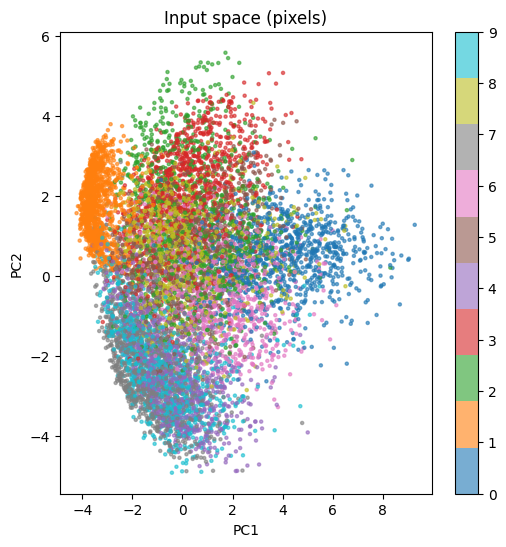

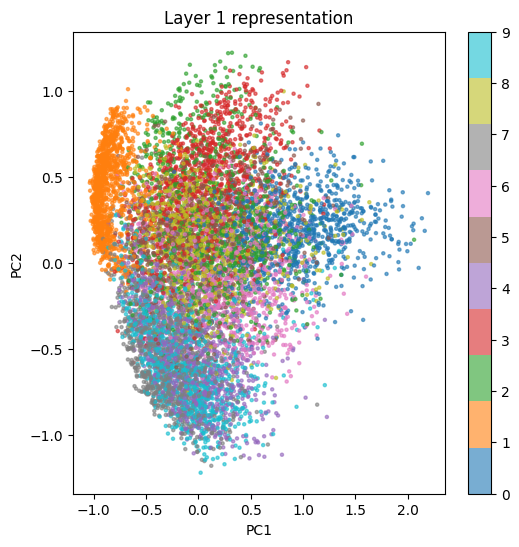

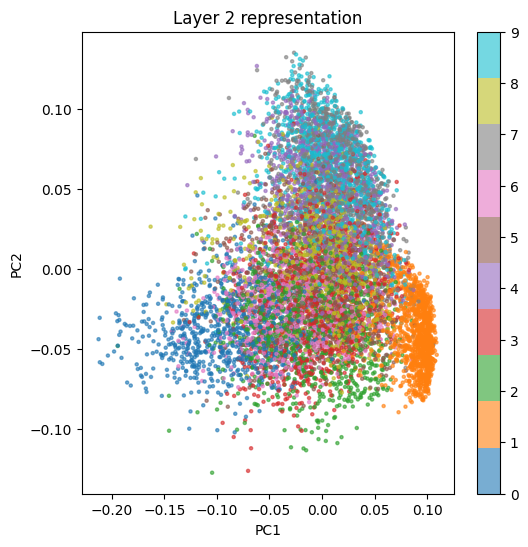

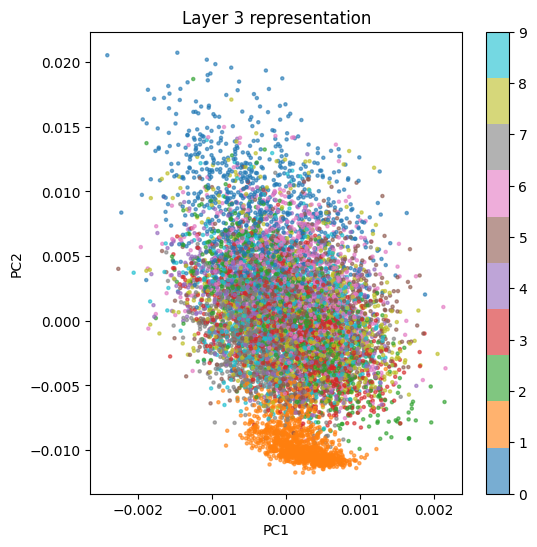

In [25]:
plot_pca(X.numpy(),  y.numpy(),  "Input space (pixels)")
plot_pca(H1.numpy(), y.numpy(),  "Layer 1 representation")
plot_pca(H2.numpy(), y.numpy(),  "Layer 2 representation")
plot_pca(H3.numpy(), y.numpy(),  "Layer 3 representation")

In [27]:
def plot_umap(Z, labels, title):
    Z_2d = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(Z)

    plt.figure(figsize=(6,6))
    scatter = plt.scatter(
        Z_2d[:,0], Z_2d[:,1],
        c=labels, cmap="tab10", s=5, alpha=0.6
    )
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

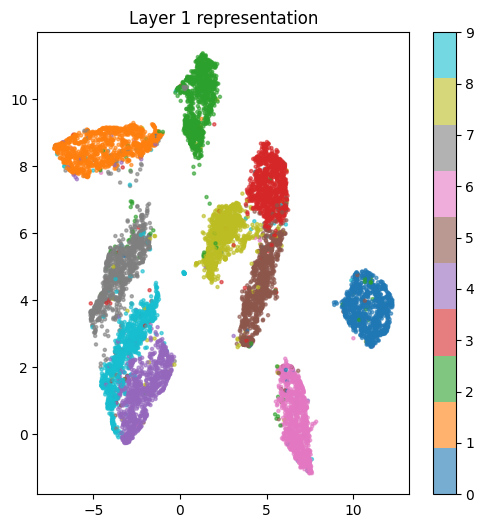

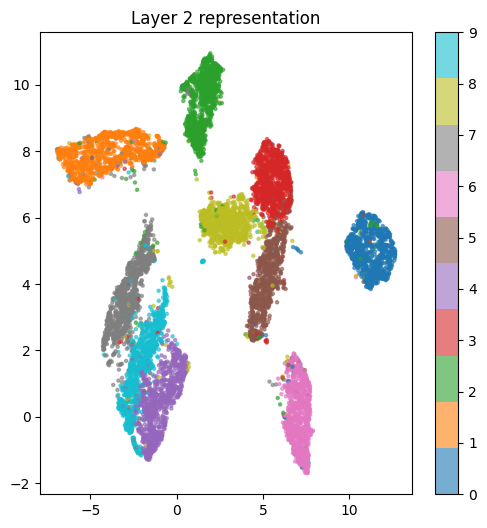

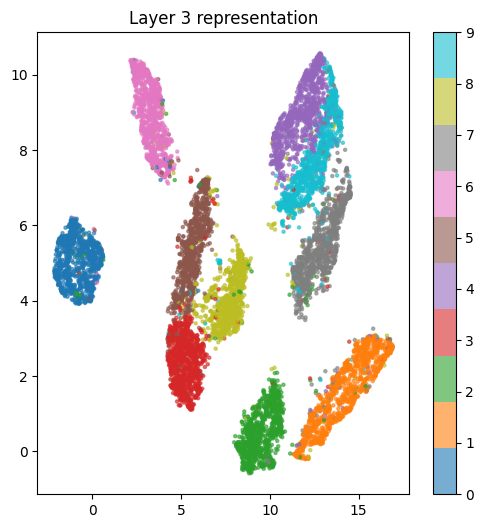

In [28]:
plot_umap(H1.numpy(), y.numpy(),  "Layer 1 representation")
plot_umap(H2.numpy(), y.numpy(),  "Layer 2 representation")
plot_umap(H3.numpy(), y.numpy(),  "Layer 3 representation")

In [33]:
def mask_corrupt(x, v=0.3):
    x = x.clone()
    B, d = x.shape
    k = int(v * d)
    device = x.device  # Fixed: preserve device

    for i in range(B):
        idx = torch.randperm(d, device=device)[:k]  # Fixed: randperm on same device
        x[i, idx] = 0
    return x

def rep_distance(encoder, x, x_tilde):
    with torch.no_grad():
        return torch.norm(
            encoder(x) - encoder(x_tilde),
            dim=1
        ).mean().item()

# Usage (assuming encoder_1, encoder_2, encoder_3 exist and are on GPU)
device = next(encoder_1.parameters()).device  # Dynamically get model device

x = X[:1000].to(device)  # Fixed: move to GPU
x_tilde = mask_corrupt(x, v=0.3)

d1 = rep_distance(encoder_1, x, x_tilde)
d2 = rep_distance(encoder_2, encoder_1(x), encoder_1(x_tilde))
d3 = rep_distance(encoder_3, encoder_2(encoder_1(x)), encoder_2(encoder_1(x_tilde)))

print(d1, d2, d3)

1.1265926361083984 0.11256492882966995 0.011161689646542072


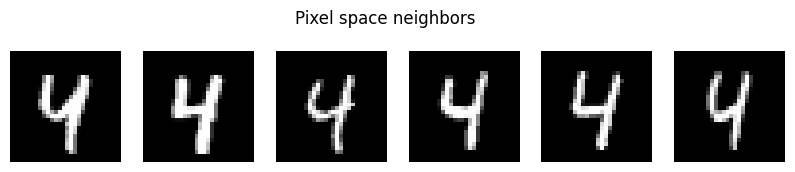

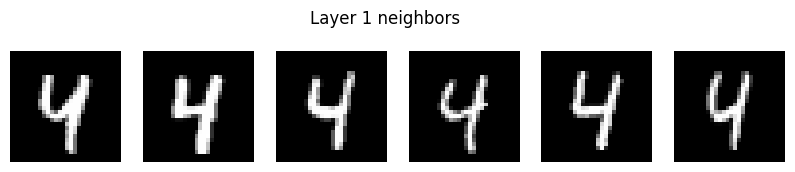

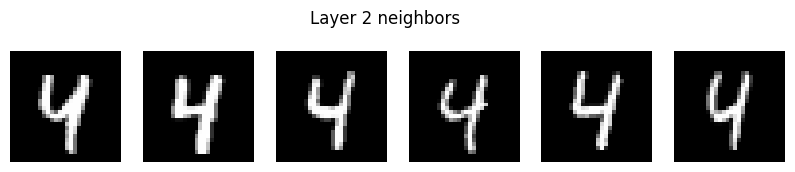

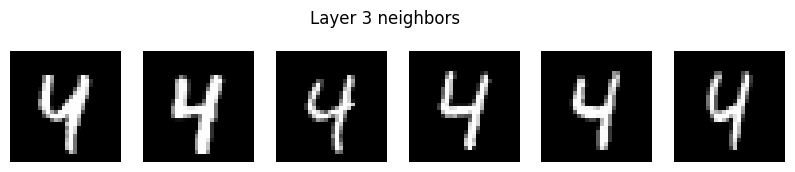

In [32]:
from sklearn.neighbors import NearestNeighbors

def nearest_neighbors(Z, idx, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(Z)
    _, indices = nbrs.kneighbors(Z[idx:idx+1])
    return indices[0][1:]
def show_neighbors(Z, idx, title):
    nn_idx = nearest_neighbors(Z, idx)
    
    plt.figure(figsize=(10,2))
    for i, j in enumerate([idx] + list(nn_idx)):
        plt.subplot(1,6,i+1)
        plt.imshow(X[j].reshape(28,28), cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

i = 42
show_neighbors(X.numpy(),  i, "Pixel space neighbors")
show_neighbors(H1.numpy(), i, "Layer 1 neighbors")
show_neighbors(H2.numpy(), i, "Layer 2 neighbors")
show_neighbors(H3.numpy(), i, "Layer 3 neighbors")